# Classification Chapter

# MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

<function matplotlib.pyplot.show(*args, **kw)>

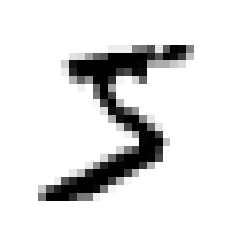

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show

In [4]:
import numpy as np

y[0] ## is a string must turn this into number
y = y.astype(np.uint8)
y[0]

5

In [5]:
## creating the train and the test set as always, the MNIST dataset is 
## already split into a training set(the first 60,000 images) and a test
## set (the last 10,000) images.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [6]:
## first of all i'll try to identify if the number is a 5
y_train_5 = (y_train == 5) ## labels of the train set, 60,000 in size
y_test_5 = (y_test == 5) ## labels of test set, 10,000 in size
y_train_5, y_test_5

(array([ True, False, False, ...,  True, False, False]),
 array([False, False, False, ..., False,  True, False]))

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([X_train[0]])

array([ True])

measuring performance of classifiers is trickier than that of regressors

# Performance Measures
# Many pages are dedicated to Performance Measures...

# Measuring acuracy using cross-validation:
The folowing code does roughly the same thing as the Scikit-Learn's `cross_val_score()` function, and it prints the same result

In [9]:
from sklearn.model_selection import StratifiedKFold # performs stratified sampling to produce
from sklearn.base import clone                      # folds that contain a representative ratio
                                                    # of each class
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): # Generate indices to split 
    clone_clf = clone(sgd_clf) ## using clone()                   # data into training and test set.
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    print('train_index:', train_index)
    print('test_index:', test_index)
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print('score: ', n_correct / len(y_pred), '\n-----------') ## outputs the ratio of correct predictions

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train_index: [19964 19965 19966 ... 59997 59998 59999]
test_index: [    0     1     2 ... 20331 20342 20359]
score:  0.95035 
-----------
train_index: [    0     1     2 ... 59997 59998 59999]
test_index: [19964 19965 19966 ... 40088 40125 40127]
score:  0.96035 
-----------
train_index: [    0     1     2 ... 40088 40125 40127]
test_index: [39988 39989 39990 ... 59997 59998 59999]
score:  0.9604 
-----------


In [10]:
#help(skfolds.split)

Now using the proper `cross_val_score()` function to evaluate `SGDClassifier`

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Now, demonstrating why 'accuracy' is not a got performance measure:

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
## it will output about 90% accuracy, as there are around 90% non fives in the data set

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#with this, i can get a prediction for each instance in the training set
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

A perfect classifier would have only true positives and true negatives:

In [15]:
y_train_5_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_5_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall:

In [16]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred) ## when it claims it is a 5, the sgd_clf is correct in (precision*100)% of the time
recall = recall_score(y_train_5, y_train_pred) ## (1 - recall) says % how many true 5s were not spot by the classifier
precision, recall                              ## that is it only detects (recall*100)% of the 5s    

(0.8370879772350012, 0.6511713705958311)

Tying Precision and Recall together, we have the `f1_score`, which is the harmonic mean of both:

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
## instead of calling the classifier's predict() method, you can call its decision_function() method,
## which returns a score for each instance, and then use any threshold you want to make predictions
## based on those scores:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

### The `SGDClassifier` uses a threshold equal to 0:

In [19]:
threshold = 0  #threshold from the tradeoff between Precision and Recall
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Raising the threshold:

In [20]:
threshold = 8000  #threshold from the tradeoff between Precision and Recall
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold reduces recall. That is what were previously a True positive is now a false negative. Lowering the threshold would reduce the precision.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')
#wtih 'decision_function' as the method, i'll get the scores of all instances in the training set
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

Now i'll use `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

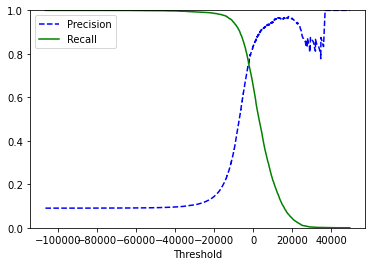

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Precision may sometimes go down when you raise the threshold.

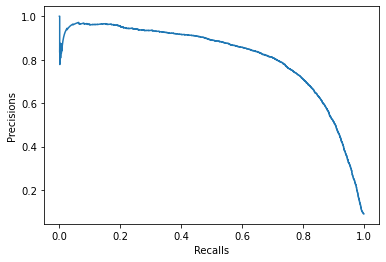

In [23]:
plt.plot(recalls, precisions)
plt.xlabel('Recalls')
plt.ylabel('Precisions')
plt.show()

Now, to show that i can create a classifier that can give me virtually any precision i want, i'll find the lowest threshold that gives me at least 90% **precision**

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# to make predictions (on the training set for now), instead of calling the classifier's predict() method,
# i'll run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Now checking these predictions' `precision` and `recall`

In [25]:
prec_s = precision_score(y_train_5, y_train_pred_90)
rec_s = recall_score(y_train_5, y_train_pred_90)
prec_s, rec_s

(0.9000345901072293, 0.4799852425751706)

90% of precision, exactly what i forced it to be, but the recall is too low. A high precision classifier is not very usefull if its recall is too low.

# The ROC curve

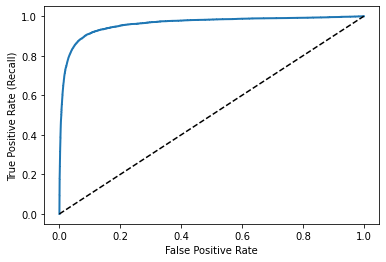

In [26]:
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_5, y_scores)
fpr, tpr = false_positive_rate, true_positive_rate

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #Dashed diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')

plot_roc_curve(fpr, tpr)
plt.show()

A good classifier will be far from the dotted line, towards the top left corner. A good way to measure the performance is to value the area under the curve (AUC). A perfect classifier will have AUC = 1, and a random one would have AUC = 0.5. We can test it with `roc_auc_score`:

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Now I'll trian a `RandomForestClassifier` and compare its ROC curve and ROC AUC to those of the `SGDClassifier`

The `RandomForestClassifier` class does not have a `decision_function()` method. Insteat it has a `predict_proba()` method.

In [28]:
## The predict_proba() method returns an array containing a row per instance
## and a column per class, each containing the probability that the given 
## instance belongs to the given class

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

The `roc_curve()` function expects labels and scores, but instead of scores I can give it class probabilities:

In [29]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now ploting the ROC curve

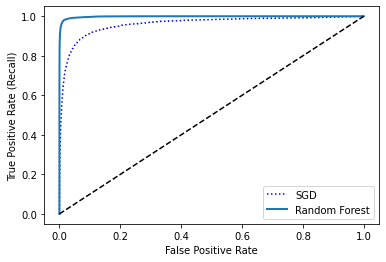

In [30]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC.

**LATER I SHOULD TRY SEEING THAT THE FOREST HAS A 99% PRECISION AND 86.6% RECAL !!!**

Message from the author of the book: "You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and use ROC curves and ROC AUC scores to compare various models."

# Multiclass Classification

### Trying a Support Vector Machine classifier:

In [32]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
## under the hood scikit-learn is using the OvO strategy: it trained 45 binary classifiers,
## when we call .predicti() it gets their decision scores for the image, and selected the class 
## that won the most duels. 

SVC()

In [33]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [35]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

I can use`OneVsOneClassifier` or `OneVsRestClassifier` classes if I wanna choose which method to use. This code creates a multiclass classifier using the OvR strategy, based on SVC:

In [36]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

Training a `SGDClassifier` (or a `RandomForestClassifier`) is just as easy:

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In the cell above Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes (as `RandomForestClassifier` can)

In [38]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

### Evaluating:

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Scaling inputs increases accuracy...

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis
Analysing the type of errors my model does

In [42]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Image representation of the confusion matrix:

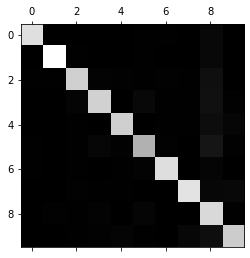

In [43]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()